# Analizar y graficar métricas de paisaje

In [1]:
import pandas, numpy, seaborn
import matplotlib.pyplot as pyplot

In [2]:
%matplotlib inline

## Organizar los datos

Las métricas calculadas por el paquete de R `landscapemetrics` deben reacomodarse antes de graficarlas para que queden en un mismo dataframe en wide format, pues ahora están separadas por paisaje y por serie.

In [3]:
def reshape_class_metrics(data):
    ''' Reacomodar los datos de las métricas por clase producidos por `landscapemetrics`.
    Recibe el data frame para un paisaje, de una serie.
    Produce data frame en wide format: cada fila corresponde a una clase, cada columna a una métrica.
    Si falta alguna de las clases que me interesan (1, 2 o 3, que corresponden a vegetación 1a, 2a o agrícola),
    se agrega una fila correspondiente y los valores de las métricas se hacen todos cero.
    '''
    
    # Dejar solamente columnas class, value, metric
    data = data.loc[:, ['class', 'value', 'metric']]
    
    # Crear MultiIndex
    index = data.loc[:, ['class', 'metric']]
    index = pandas.MultiIndex.from_frame(index)
    
    # Reshape dataframe con nuevo index y unstack
    data = pandas.DataFrame(data['value'].values, index=index, columns=['value'])
    
    data = data.unstack()
    
    # verificar que dataframe contenga las clases 1, 2, 3 o agregar una nueva fila con ceros
    for c in range(1, 4):
        try:
            data.loc[c]
            
        except KeyError:
            data.loc[c] = numpy.zeros(len(data.columns))
    
    # regresar sólo los datos para las clases 1, 2, 3
    data = data.loc[[1, 2, 3]]
    
    return data

In [4]:
def reshape_landscape_metrics(data): 
    '''Reacomodar los datos de las métricas por paisaje  producidos por `landscapemetrics`.
    '''
    
    # extract value column and reshape horizontally so that it fits df
    data_values = data['value'].values.reshape((1, len(data['value'])))
    
    data = pandas.DataFrame(data_values, columns=data['metric'].values, index=[1])
    
    return data

In [5]:
# información que necesitamos para crear los data frames

num_distritos = 5 # número de distritos / paisajes para los que calculé métricas
num_series = 5 # número de series / puntos en el tiempo
num_clases = 3 # número de clases que me interesan

key_c_metrics = ['ai', 'area_mn', 'ca','ed', 'iji', 'lpi', 'np'] # metricas de clase que me interesan
key_l_metrics = ['shdi', 'condent', 'ta', 'contag'] # métricas del paisaje que me interesan

In [6]:
# crear un multi index para el dataframe de clase y paisaje

c_index = pandas.MultiIndex.from_product([list(range(1, num_distritos+1)),
                                      list(range(2, num_series+2)),
                                      list(range(1, num_clases+1))],
                                      names = ['distrito', 'serie', 'clase'])

l_index = pandas.MultiIndex.from_product([list(range(1, num_distritos+1)),
                                      list(range(2, num_series+2))],
                                      names = ['distrito', 'serie'])

In [7]:
# crear data frames
metricas_clase = pandas.DataFrame(index=c_index, columns=key_c_metrics)
metricas_paisaje = pandas.DataFrame(index=l_index, columns = key_l_metrics)

In [8]:
idx = pandas.IndexSlice

In [9]:
# leer datos e integrarlos dataframes para nivel de clase y paisaje, respectivamente

for distrito in range(1, num_distritos+1):

    for serie in range(2, num_series+2):
        
        # leer datos para clase y paisaje
        clase = pandas.read_csv('./resultados/datos_procesados/metricas/paisaje{}_serie{}_class.csv'
                                .format(distrito, serie), encoding ='ISO-8859-1', header=0)
        paisaje = pandas.read_csv('./resultados/datos_procesados/metricas/paisaje{}_serie{}_landscape.csv'
                                  .format(distrito, serie), encoding ='ISO-8859-1', header=0)
        
        # reshape data and add to df
        clase = reshape_class_metrics(clase)
                
        metricas_clase.loc[idx[distrito, serie], 
                           key_c_metrics] = clase.loc[:, idx[:, key_c_metrics]].values
        
        paisaje = reshape_landscape_metrics(paisaje)
        
        metricas_paisaje.loc[idx[distrito, serie], 
                             key_l_metrics] = paisaje.loc[:, key_l_metrics].values

In [10]:
metricas_paisaje

shdi   condent     ta   contag
distrito serie                                     
1        2       0.986861  0.533104  90000  57.8617
         3       0.865251  0.579043  90000  64.6545
         4       0.954921  0.737612  90000  59.0851
         5       0.972724  0.799808  90000  57.3852
         6        1.00806  0.867691  90000  55.0861
2        2       0.753349  0.438148  90000  67.1609
         3       0.500122  0.340129  90000  73.4587
         4       0.579764  0.421152  90000  68.5606
         5       0.603109  0.505193  90000  65.6176
         6       0.657979  0.581162  90000  51.7205
3        2       0.200061  0.117253  90000  87.1959
         3      0.0763936  0.042064  90000  95.1962
         4      0.0763936  0.042064  90000  95.1962
         5       0.469791  0.253967  90000  70.6071
         6       0.660166  0.332308  90000  59.4714
4        2       0.460167  0.278882  90000  79.6987
         3       0.787313  0.572437  90000  57.2928
         4       0.797544  0.587058  90000  56.5582
         5       0.816408  0.637578  90000  54.6149
         6       0.800893  0.710284  90000  53.3568
5        2       0.400072  0.181611  90000  81.0302
         3       0.321968  0.162448  90000  84.3263
         4        0.35919  0.181778  90000  84.9268
         5       0.351814  0.183752  90000  85.1134
         6       0.385196  0.225375  90000    83.18

In [11]:
# calcular área relativa de clase
metricas_clase['% ca'] = metricas_clase['ca'] / metricas_paisaje['ta'] * 100

In [12]:
metricas_clase

ai  area_mn       ca        ed      iji       lpi  \
distrito serie clase                                                           
1        2     1      92.5169  3754.17  33787.5   4.62778  44.8297   21.3542   
               2      93.3228  6844.64  47912.5   6.05556   69.354   45.5764   
               3      77.2512  235.817  6131.25       2.6  64.1169   1.54861   
         3     1      86.6536  746.591   8212.5   2.13889  47.3064   2.45833   
               2       93.838  9190.18  64331.2   7.16667  48.9096   65.6806   
...                       ...      ...      ...       ...      ...       ...   
5        5     2      98.4123  27533.3    82600   2.47222  48.3597   91.6736   
               3      75.0955  152.009  4256.25   1.98333  5.74024  0.590278   
         6     1      92.4617  929.167   2787.5  0.516667  48.2122   2.70139   
               2      97.9735  27172.9  81518.8   3.07222  41.2296   90.4722   
               3      73.3056  139.583  5443.75       2.7  14.1884  0.930556   

                      np     % ca  
distrito serie clase               
1        2     1       9  37.5417  
               2       7  53.2361  
               3      26   6.8125  
         3     1      11    9.125  
               2       7  71.4792  
...                   ..      ...  
5        5     2       3  91.7778  
               3      28  4.72917  
         6     1       3  3.09722  
               2       3  90.5764  
               3      39  6.04861  

[75 rows x 8 columns]

La sintaxis para buscar o seleccionar dentro del dataframe de `metricas_clase` es:

`metricas_clase.loc[idx[distrito, serie, clase], idx['metrica1', 'metrica2']]`. Por ejemplo:

In [13]:
metricas_clase.loc[idx[1, :, :], idx['% ca', 'ca']]

% ca       ca
distrito serie clase                  
1        2     1      37.5417  33787.5
               2      53.2361  47912.5
               3       6.8125  6131.25
         3     1        9.125   8212.5
               2      71.4792  64331.2
               3      16.7917  15112.5
         4     1      7.13194  6418.75
               2      61.2292  55106.2
               3      29.0347  26131.2
         5     1      6.49306  5843.75
               2      58.9792  53081.2
               3      31.6458  28481.2
         6     1      5.72917  5156.25
               2      48.9861  44087.5
               3      42.1667    37950

In [29]:
metricas_clase.to_csv('./resultados/datos_procesados/metricas_clase.csv')

In [30]:
metricas_paisaje.to_csv('./resultados/datos_procesados/metricas_paisaje.csv')

## ¡Visualizar métricas!

Primero, algunos parámetros de estilo.

In [14]:
Clases = {'primaria':1.0, 'secundaria':2.0, 'agricola':3.0}
Clases_colores = {1:'DarkGreen', 2: 'LimeGreen', 3:'DarkGoldenrod'}

In [ ]:
# valores y etiquetas del eje x
x = [1993, 2002, 2007, 2011, 2015]
x_labels = ['1993', '2002', '2007', '2011', '2015']

In [16]:
# límites del eje y para las métricas de clase
Ylim_class = {'ed':(-0.7, 15), 'iji': (-.7, 90), 'lpi':(-0.7, 100),
              'np':(-0.7, 120), '% ca': (-0.7, 101),}

# límites del eje y para las métricas de paisaje
Ylim_landscape = {'shdi': (0, 1.05), 'condent':(0, 1.05)}

In [15]:
def set_style():
    pyplot.style.use('seaborn-white')
    pyplot.rcParams['axes.labelsize'] = 12
    pyplot.rcParams['axes.titlesize'] = 12
    pyplot.rcParams['xtick.labelsize'] = 12
    pyplot.rcParams['ytick.labelsize'] = 12

En todas las gráficas, cada fila corresponde a una métrica y cada columna a un distrito / paisaje.

In [48]:
def plot_class_metrics():
    metricas = ['% ca','np', 'ed', 'lpi', 'iji']
    fig, ax = pyplot.subplots(5, len(metricas), figsize=(11, 9))
    
    for m, metrica in enumerate(metricas):
        for distrito, d in enumerate(range(1, 6)):
            
            # límites de las gráficas
            ax[m, d-1].set_xlim(1992, 2017)
            ax[m, d-1].set_ylim(Ylim_class[metrica])

            # mantener etiquetas del eje x sólo para la última fila ie métrica = 'iji'
            if metrica == 'iji':        
                ax[m, d-1].set_xticks(x)
                ax[m, d-1].set_xticklabels(x_labels, rotation=45)
            else:
                ax[m, d-1].set_xticks([])
            
            # mantener etiquetas del eje y sólo para la primera columna, ie distrito = 1
            if d != 1:
                ax[m, d-1].set_yticks([])
                
            #ax[m, d-1].set_ylabel(metrica)

            
            for clase in [3, 2, 1]:
                if ((d == 3) or (d == 4)) and clase == 1: # en estos paisajes no hay vegetación 1a
                    pass
                else:
                    heights = metricas_clase.loc[idx[d, :, clase], metrica].values
                    ax[m, d-1].plot(x, heights, marker=None, color=Clases_colores[clase], ms=12, lw=6)
                    #ax[m, d-1].set_title('distrito {}'.format(d))

    pyplot.tight_layout()
    #pyplot.savefig('2019-09-01_tendencias.png', dpi = 300)
    
    return fig, ax

In [41]:
set_style()

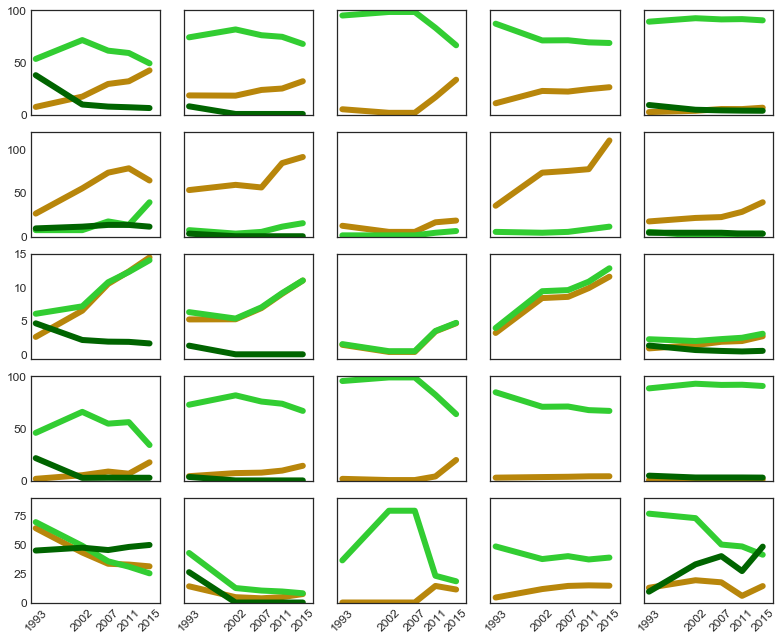

In [49]:
plot_class_metrics();

In [45]:
def plot_class_metrics_agricola():
    metricas = ['np', 'lpi', 'iji']
    
    # el eje y necesita límites diferentes a Ylim_class
    Ylim = {'iji': (-.7, 70), 'lpi':(-0.7, 30), 'np':(-0.7, 120)}
   
    fig, ax = pyplot.subplots(len(metricas), 5, figsize=(10, 5))
    
    for m, metrica in enumerate(metricas):
        for distrito, d in enumerate(range(1, 6)):
            
            # límites de las gráficas
            ax[m, d-1].set_xlim(1992, 2017)
            ax[m, d-1].set_ylim(Ylim[metrica])

            # mantener etiquetas del eje x sólo para la última fila ie métrica = 'iji'
            if metrica == 'iji':        
                ax[m, d-1].set_xticks(x)
                ax[m, d-1].set_xticklabels(x_labels, rotation=45)
            else:
                ax[m, d-1].set_xticks([])
            
            # mantener etiquetas del eje y sólo para la primera columna, ie distrito = 0
            if d != 1:
                ax[m, d-1].set_yticks([])
                
            #ax[m, d-1].set_ylabel(metrica)

            
            for clase in [3]:
                if ((d == 3) or (d == 4)) and clase == 1: 
                    pass
                else:
                    heights = metricas_clase.loc[idx[d, :, clase], metrica].values
                    ax[m, d-1].plot(x, heights, marker=None, color=Clases_colores[clase], ms=12, lw=6)
                    #ax[m, d-1].set_title('distrito {}'.format(d))

    pyplot.tight_layout()
    #pyplot.savefig('2019-09-29_tendencias_agricola.png', dpi = 300)
    
    return fig, ax

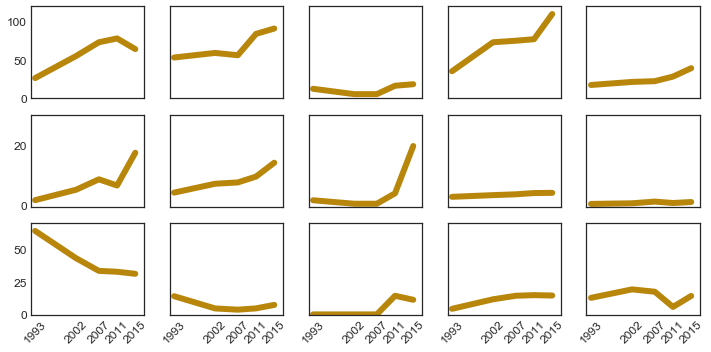

In [46]:
plot_class_metrics_agricola();

In [101]:
# para graficar métrica por métrica
def plot_class_metrics_final_c():
    metricas = ['% ca','np', 'ed', 'lpi', 'iji']
    fig, ax = pyplot.subplots(5, len(metricas), figsize=(12, 11))
    
    for m, metrica in enumerate(metricas):
        for distrito, d in enumerate(range(1, 6)):
            
            # límites de las gráficas
            ax[m, d-1].set_xlim(1992, 2017)
            ax[m, d-1].set_ylim(Ylim_class[metrica])

            # mantener las etiquetas del eje x para todas las métricas
            ax[m, d-1].set_xticks(x)
            ax[m, d-1].set_xticklabels(x_labels, rotation=45)
            
            # mantener etiquetas del eje y sólo para la primera columna, ie distrito = 0
            if d != 1:
                ax[m, d-1].set_yticks([])
                
            #ax[m, d-1].set_ylabel(metrica)

            
            for clase in [3, 2, 1]:
                if ((d == 3) or (d == 4)) and clase == 1: # en estos paisajes no hay vegetación 1a
                    pass
                else:
                    heights = metricas_clase.loc[idx[d, :, clase], metrica].values
                    ax[m, d-1].plot(x, heights, marker=None, color=Clases_colores[clase], ms=12, lw=6)
                    #ax[m, d-1].set_title('distrito {}'.format(d))

    pyplot.tight_layout()
    #pyplot.savefig('2019-09-01_allmetrics.png', dpi = 300)
    
    return fig, ax

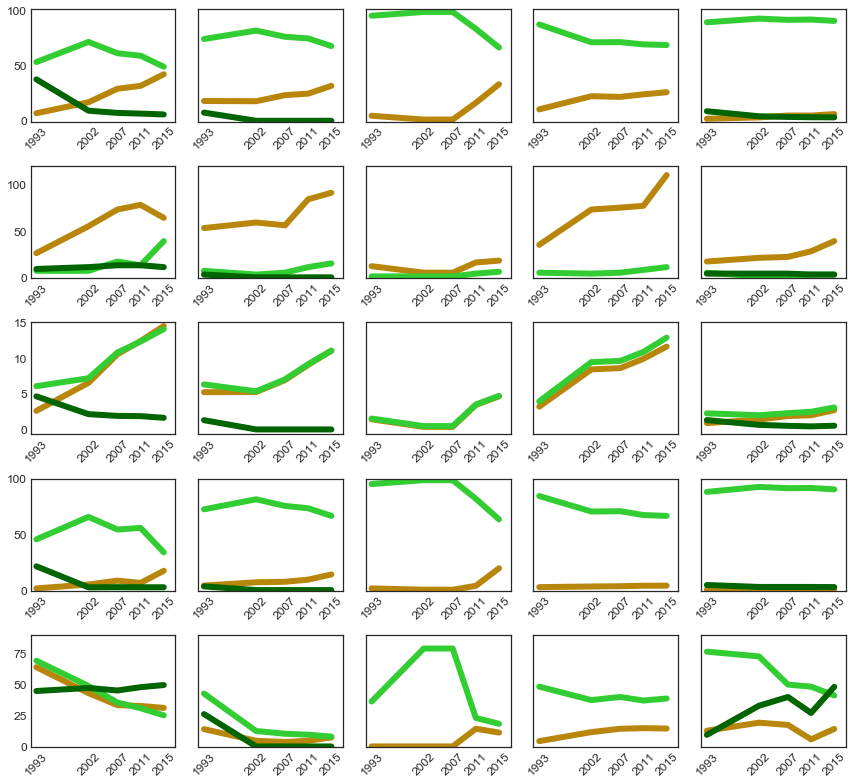

In [102]:
plot_class_metrics_final_c();

In [344]:
#pyplot.savefig('tendencias.png', dpi = 300)

<Figure size 432x288 with 0 Axes>

In [138]:
# otro criterio de conservación
def plot_landscape_metrics_final():
    metricas = ['shdi', 'condent']
    fig, ax = pyplot.subplots(len(metricas), 5, figsize=(14, 5))
    
    for m, metrica in enumerate(metricas):
        for distrito, d in enumerate(range(1, 6)):
            ax[m, d-1].set_xticks(x)
            ax[m, d-1].set_xlim(1992, 2017)
            ax[m, d-1].set_ylim(Ylim_landscape[metrica])

            ax[m, d-1].set_ylabel('distrito {}'.format(d))

            heights = metricas_paisaje.loc[idx[d, :], metrica].values
            ax[m, d-1].plot(x, heights, marker=None, color='MidnightBlue', ms=12, lw=6)
            ax[m, d-1].set_title(metrica)


    pyplot.tight_layout()
    #pyplot.savefig('2019-08-31_tendencias_paisaje.png', dpi = 300)
    
    return fig, ax

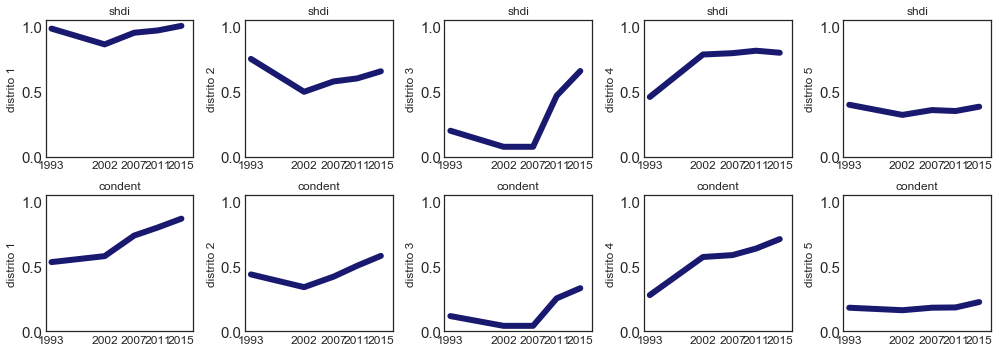

In [139]:
plot_landscape_metrics_final();

In [72]:
def plot_all_metrics():    
    fig, ax = pyplot.subplots(7, 5, figsize=(11, 12))
    
    # Métricas de clase
    metricas_c = ['% ca','np', 'ed', 'lpi', 'iji']

    for m, metrica in enumerate(metricas_c):
        for distrito, d in enumerate(range(1, 6)):
            
            # límites de las gráficas
            ax[m, d-1].set_xlim(1992, 2017)
            ax[m, d-1].set_ylim(Ylim_class[metrica])

            # mantener etiquetas del eje x sólo para la última fila ie métrica = 'iji'
            if metrica == 'condent':        
                ax[m, d-1].set_xticks(x)
                ax[m, d-1].set_xticklabels(x_labels, rotation=45)
            else:
                ax[m, d-1].set_xticks([])
            
            # mantener etiquetas del eje y sólo para la primera columna, ie distrito = 0
            if d != 1:
                ax[m, d-1].set_yticks([])
                
            #ax[m, d-1].set_ylabel(metrica)

            for clase in [3, 2, 1]:
                if ((d == 3) or (d == 4)) and clase == 1: 
                    pass
                else:
                    heights = metricas_clase.loc[idx[d, :, clase], metrica].values
                    ax[m, d-1].plot(x, heights, marker=None, color=Clases_colores[clase], ms=12, lw=6)
                    #ax[m, d-1].set_title('distrito {}'.format(d))
            
    # Métricas de paisaje
    metricas_l = ['shdi', 'condent']
            
    for m, metrica in enumerate(metricas_l):
        for distrito, d in enumerate(range(1, 6)):
            #ax[m+5, d-1].set_xticks(x)
            ax[m+5, d-1].set_xlim(1992, 2017)
            ax[m+5, d-1].set_ylim(Ylim_landscape[metrica])
            
            # mantener etiquetas del eje x sólo para la última fila ie métrica = 'iji'
            if metrica == 'condent':        
                ax[m+5, d-1].set_xticks(x)
                ax[m+5, d-1].set_xticklabels(x_labels, rotation=45)
            else:
                ax[m+5, d-1].set_xticks([])
            
            # mantener etiquetas del eje y sólo para la primera columna, ie distrito = 1
            if d != 1:
                ax[m+5, d-1].set_yticks([])
            #ax[m+5, d-1].set_ylabel('distrito {}'.format(d))

            heights = metricas_paisaje.loc[idx[d, :], metrica].values
            ax[m+5, d-1].plot(x, heights, marker=None, color='MidnightBlue', ms=12, lw=6)
            #ax[m+5, d-1].set_title(metrica)

                    
    pyplot.tight_layout()
    #pyplot.savefig('2019-09-29_tendencias_all.png', dpi = 300)
    
    return fig, ax

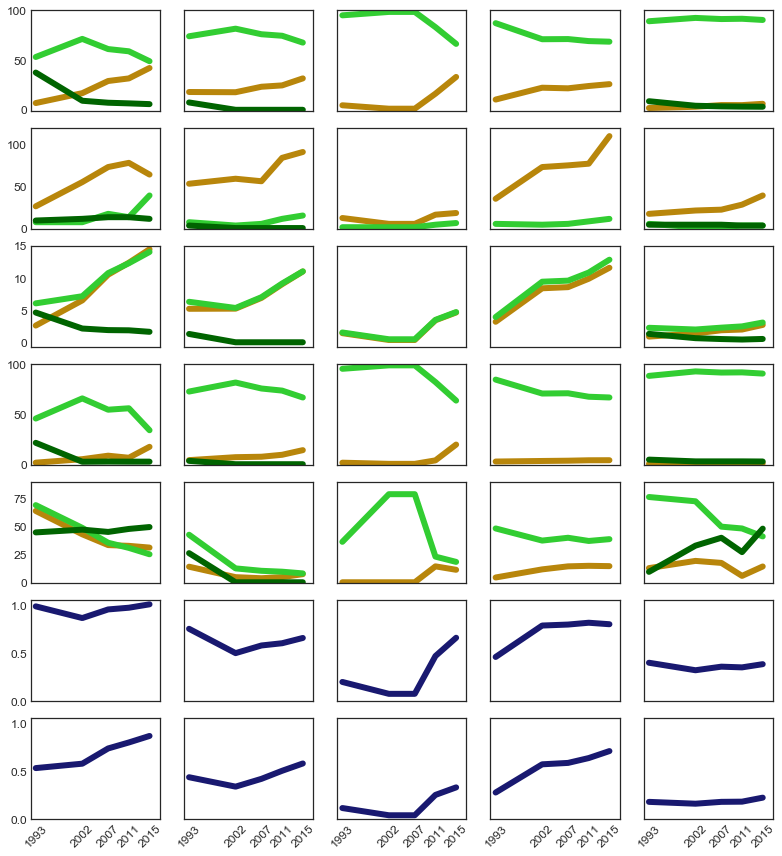

In [73]:
plot_all_metrics();